In [87]:
from common import *
from process_ntuples import *
from process_df import *
from plotting import *
from cuts import apply_cuts, apply_pt_cut
import matplotlib.pyplot as plt

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras import layers

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from tensorflow.keras.callbacks import EarlyStopping

#weights and biases imports
import wandb
from wandb.keras import WandbMetricsLogger, WandbModelCheckpoint, WandbCallback

import random
import numpy as np
import tensorflow as tf

Welcome to JupyROOT 6.28/00


In [19]:
dir_path = "/global/cfs/cdirs/atlas/gottino/Charm/Analysis/run_batch_gup/ntuples"

files = os.listdir(dir_path)
TTree = process_ntuple(dir_path, files[0])
files

['CharmAnalysis.mc.ForcedDecay.Dplus.tree.root',
 'CharmAnalysis.mc.ForcedDecay.LabmdaC.tree.root']

$D^{+}$ : 411

$\Lambda_C^{+}$ : 4122

Apply Cuts Fiducial Region cuts ($𝐷^{+}$ $𝑝_T$ > 8 GeV, |𝜂| < 2.2). ***See cuts.py on how the cuts are applied***

In [219]:
DMesons_df = show(0, TTree, ["DMesons_pt","DMesons_eta", "DMesons_m", "DMesons_fitOutput__Lxy", "DMesons_costhetastar", "DMesons_pdgId"], 20000)
DMesons_df = remove_empty(DMesons_df)

DMesons_df["DMesons_pt"] = DMesons_df["DMesons_pt"].apply(divide_by_1000)
for col in DMesons_df.columns:
    DMesons_df[col] = DMesons_df[col].apply(list)
    
DMesons_df = apply_cuts(DMesons_df)
pd.set_option('display.max_rows', 10)
DMesons_df

,DMesons_pt,DMesons_eta,DMesons_m,DMesons_fitOutput__Lxy,DMesons_costhetastar,DMesons_pdgId
0,(10.047125),[0.08182407170534134],[1862.4176025390625],[2.3395302295684814],[0.25487038493156433],[411]
1,"(18.9937421875, 18.9937421875)","[-1.6619627475738525, -1.6619627475738525]","[1853.90625, 2398.886962890625]","[1.9184143543243408, 1.9184143543243408]","[-0.36730244755744934, -0.0650731548666954]","[411, 4122]"
2,"(10.118494140625, 10.118494140625)","[0.041659336537122726, 0.041659336537122726]","[1874.203125, 2468.1806640625]","[2.8901257514953613, 2.8901257514953613]","[0.06833142042160034, 0.4276972711086273]","[411, 4122]"
3,"(12.579470703125, 12.579470703125)","[-1.1025604009628296, -1.1025604009628296]","[1884.987060546875, 2220.384521484375]","[0.9249186515808105, 0.9249186515808105]","[-0.5603189468383789, -0.41332852840423584]","[411, 4122]"
4,(36.1288359375),[0.6598162055015564],[2235.69873046875],[0.3584118187427521],[0.19036155939102173],[4122]
...,...,...,...,...,...,...
8333,"(14.0556298828125, 14.0556298828125, 14.055629...","[-0.2029181867837906, -0.2029181867837906, -0....","[1877.5616455078125, 2437.9541015625, 2371.815...","[3.2642693519592285, 3.2642693519592285, 3.264...","[-0.45191243290901184, 0.016617078334093094, -...","[411, 4122, 4122]"
8334,(8.5570830078125),[-1.1406751871109009],[2365.51904296875],[0.11108941584825516],[0.7960365414619446],[4122]
8335,(31.940462890625),[-2.006657361984253],[2077.287109375],[0.10074585676193237],[0.6881166696548462],[4122]
8336,"(35.01245703125, 35.01245703125)","[0.14026063680648804, 0.14026063680648804]","[1858.9073486328125, 2130.3583984375]","[1.3225394487380981, 1.3225394487380981]","[-0.9133811593055725, -0.8799314498901367]","[411, 4122]"


In [7]:
DMesons_df2 = show(0, TTree, ["DMesons_daughterInfo__pt", "DMesons_daughterInfo__eta", "DMesons_daughterInfo__phi", "DMesons_daughterInfo__pdgId"], 100)
DMesons_df2 = remove_empty(DMesons_df2)

In [9]:
DPlus = [-321, 211, 211]
LambdaC = [2212, -321, 211]

remove_lambda = []

count = 0
for index, row in DMesons_df2.iterrows():
    if count == 50:
        break
    count+=1
    
    pts = row['DMesons_daughterInfo__pt']
    etas = row['DMesons_daughterInfo__eta']
    phis = row['DMesons_daughterInfo__phi']
    pdgids = row["DMesons_daughterInfo__pdgId"]
    
    #loop through until the first lambda encountered
    for i in range(len(pdgids) - 1):
        #if there are multiple lambda baryons
        if len(pdgids) > 2:
            #stop at the first lambda and keep the higher proton pt valued lambda
            if list(pdgids[i]) == LambdaC:
                l1_pt, l2_pt = pts[i][0], pts[i + 1][0]
                if (l1_pt > l2_pt):
                    #Lambda 1's proton has higher pt
                    remove_lambda.append((index, i + 1))
                elif (l1_pt < l2_pt):
                    #Lambda 2's proton has higher pt!
                    remove_lambda.append((index, i))
                else:
                    raise Exception("Error: Are the proton pt vaules equal?")
                    
len(remove_lambda)

3

In [24]:
#takes tuples of shape (2,) / (index, column)
def remove_particles_from_df(df, tuple_list):
    for tup in tuple_list:
        index, column = tup
        print(index, column)
        
        new_df = df.copy()
        for i in range(len(DMesons_df.iloc[index, 0][column]) + 1):
            #new_df["DMesons_daughterInfo__pt"] = new_df["DMesons_daughterInfo__pt"].apply(lambda x: print(x))
            val = new_df.iloc[index, i][column]
            print(val)
    df = df.drop(index, axis = 0)
    return df
#df = remove_particles_from_df(DMesons_df, remove_lambda)

#for now just remove the rows
indices = [i for i, x in enumerate(DMesons_df2[DMesons_df2.columns[0]]) if len(x) > 2]
DMesons_df2 = DMesons_df2.drop(indices)
DMesons_df2 = DMesons_df2.reset_index(drop=True)
DMesons_df2["DMesons_daughterInfo__pt"] = DMesons_df2["DMesons_daughterInfo__pt"].apply(divide_by_1000)
DMesons_df2

pd.set_option('display.max_rows', 10)
# pd.set_option('display.max_columns', None)

# print("-----------------")
# print(DMesons_df.iloc[32, 0][2])
# print(DMesons_df.iloc[32, 1][2])
# print(DMesons_df.iloc[32, 2][2])
# print(DMesons_df.iloc[32, 3][2])

In [183]:
# create a new column 'particle_type' based on the pdgId column
func = lambda x: 'only_411' if x == [411] else ('only_4122' if x == [4122] else 'both')
DMesons_df['particle_type'] = DMesons_df['DMesons_pdgId'].apply(func)

# separate the rows based on the new column
only_411 = DMesons_df[DMesons_df['particle_type'] == 'only_411']
only_4122 = DMesons_df[DMesons_df['particle_type'] == 'only_4122']
both = DMesons_df[DMesons_df['particle_type'] == 'both']

new_df = DMesons_df[DMesons_df['particle_type'] != 'both']
new_df = new_df.reset_index(drop=True)
new_df.loc[:, 'DMesons_pt'] = new_df['DMesons_pt'].apply(lambda x: float(x[0]))
new_df.loc[:, 'DMesons_fitOutput__Lxy'] = new_df['DMesons_fitOutput__Lxy'].apply(lambda x: float(x[0]))
new_df.loc[:, 'DMesons_costhetastar'] = new_df['DMesons_costhetastar'].apply(lambda x: float(x[0]))
new_df.loc[:, 'DMesons_pdgId'] = new_df['DMesons_pdgId'].apply(lambda x: int(x[0]))
new_df = new_df.drop('particle_type', axis=1)
new_df

,DMesons_pt,DMesons_fitOutput__Lxy,DMesons_costhetastar,DMesons_pdgId
0,10.047125,2.339530,0.254870,411
1,36.128836,0.358412,0.190362,4122
2,14.835231,2.899070,0.684572,411
3,8.800141,0.246351,-0.737246,4122
4,30.092365,7.426617,-0.937342,4122
...,...,...,...,...
2516358,24.477744,3.593372,0.539289,411
2516359,14.971446,2.374407,0.863583,411
2516360,12.734207,5.151422,0.461929,411
2516361,17.960000,5.878625,0.452780,411


In [7]:
D = 0
Lambda = 0
for pdgId in new_df["DMesons_pdgId"]:
    if pdgId == 411:
        D+=1
    elif pdgId == 4122:
        Lambda+=1
print(D, Lambda)

1566841 949522


In [195]:
only_411 = only_411.reset_index(drop=True)
only_411.loc[:, 'DMesons_pt'] = only_411['DMesons_pt'].apply(lambda x: float(x[0]))
only_411.loc[:, 'DMesons_fitOutput__Lxy'] = only_411['DMesons_fitOutput__Lxy'].apply(lambda x: float(x[0]))
only_411.loc[:, 'DMesons_costhetastar'] = only_411['DMesons_costhetastar'].apply(lambda x: float(x[0]))
only_411.loc[:, 'DMesons_pdgId'] = only_411['DMesons_pdgId'].apply(lambda x: int(x[0]))
only_411 = only_411.drop('particle_type', axis=1)

only_4122 = only_4122.reset_index(drop=True)
only_4122.loc[:, 'DMesons_pt'] = only_4122['DMesons_pt'].apply(lambda x: float(x[0]))
only_4122.loc[:, 'DMesons_fitOutput__Lxy'] = only_4122['DMesons_fitOutput__Lxy'].apply(lambda x: float(x[0]))
only_4122.loc[:, 'DMesons_costhetastar'] = only_4122['DMesons_costhetastar'].apply(lambda x: float(x[0]))
only_4122.loc[:, 'DMesons_pdgId'] = only_4122['DMesons_pdgId'].apply(lambda x: int(x[0]))
only_4122 = only_4122.drop('particle_type', axis=1)

only_411

,DMesons_pt,DMesons_fitOutput__Lxy,DMesons_costhetastar,DMesons_pdgId
0,10.047125,2.339530,0.254870,411
1,14.835231,2.899070,0.684572,411
2,9.691489,1.241371,0.439036,411
3,28.525160,1.982312,0.528804,411
4,40.980965,4.664388,0.302332,411
...,...,...,...,...
1566836,23.254861,1.341532,0.385443,411
1566837,24.477744,3.593372,0.539289,411
1566838,14.971446,2.374407,0.863583,411
1566839,12.734207,5.151422,0.461929,411


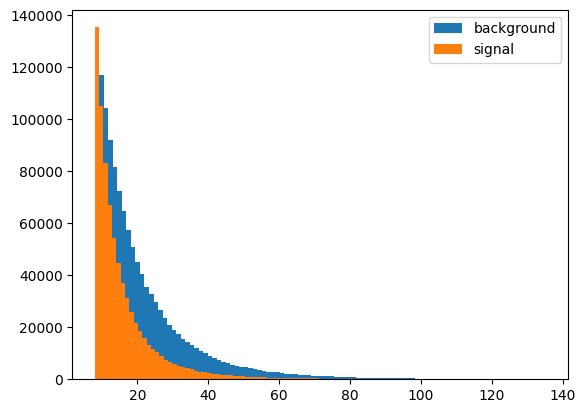

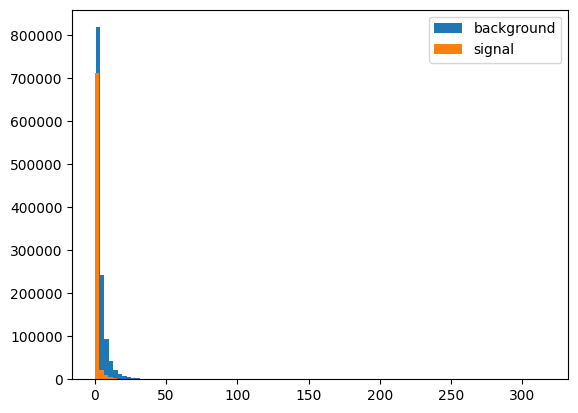

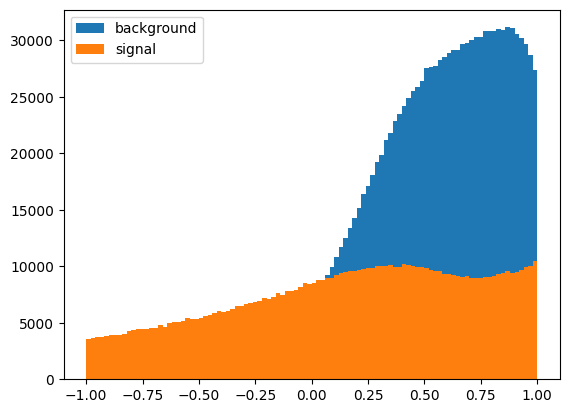

In [177]:
plt.figure()
hists = plt.hist(X_train1["DMesons_pt"], bins = 100, label = "background")
hists = plt.hist(X_train2["DMesons_pt"], bins = 100, label = "signal")
plt.legend()
plt.show()

plt.figure()
hists1 = plt.hist(X_train1["DMesons_fitOutput__Lxy"], bins = 100, label = "background")
hists1 = plt.hist(X_train2["DMesons_fitOutput__Lxy"], bins = 100, label = "signal")
plt.legend()
plt.show()

plt.figure()
hists2 = plt.hist(X_train1["DMesons_costhetastar"], bins = 100, label = "background")
hists2 = plt.hist(X_train2["DMesons_costhetastar"], bins = 100, label = "signal")
plt.legend()
plt.show()

In [196]:
#D and Lambda
new_df['DMesons_pdgId'] = new_df['DMesons_pdgId'].replace({411: 0, 4122: 1})
X_train, X_test, y_train, y_test = train_test_split(new_df[['DMesons_pt', 'DMesons_fitOutput__Lxy', 'DMesons_costhetastar']], new_df['DMesons_pdgId'], test_size=0.2, random_state=42)

#only DMesons
only_411['DMesons_pdgId'] = only_411['DMesons_pdgId'].replace({411: 0, 4122: 1})
X_train1, X_test1, y_train1, y_test1 = train_test_split(only_411[['DMesons_pt', 'DMesons_fitOutput__Lxy', 'DMesons_costhetastar']], only_411['DMesons_pdgId'], test_size=0.2, random_state=42)

#only Lambda
only_4122['DMesons_pdgId'] = only_4122['DMesons_pdgId'].replace({411: 0, 4122: 1})
X_train2, X_test2, y_train2, y_test2 = train_test_split(only_4122[['DMesons_pt', 'DMesons_fitOutput__Lxy', 'DMesons_costhetastar']], only_4122['DMesons_pdgId'], test_size=0.2, random_state=42)

In [197]:
print(np.shape(X_train), np.shape(X_test))
X_train

(2013090, 3) (503273, 3)


,DMesons_pt,DMesons_fitOutput__Lxy,DMesons_costhetastar
1393567,8.998823,0.415244,-0.676589
247341,16.169950,0.432640,0.822002
1720792,23.583254,1.711358,0.509549
235015,31.431924,1.232870,0.380954
1760004,24.270182,3.152954,0.582256
...,...,...,...
110268,10.439533,2.331200,0.816670
1692743,11.541045,3.062604,0.980448
2356330,8.304547,0.295519,0.010769
2229084,23.810479,4.198989,0.724207


In [10]:
wandb.init(
    # set the wandb project where this run will be logged
    project="ATLAS_DNN",

    # track hyperparameters and run metadata with wandb.config
    config={
        "layer_1": 64,
        "activation_1": "relu",
        "dropout": 0.5,
        "layer_2": 32,
        "activation_2": "relu",
        "dropout": 0.5,
        "output_layer": 1,
        "output_activation": "sigmoid",
        "optimizer": "adam",
        "loss": "binary_crossentropy",
        "metric": "accuracy",
        "epoch": 50,
        "batch_size": 32
    }
)

config = wandb.config

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: gup-singh (atlasdnn). Use `wandb login --relogin` to force relogin


In [11]:
#model
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

2023-04-03 03:17:28.703939: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [12]:
#Compile
model.compile(optimizer='adam', loss='binary_crossentropy')

early_stop = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='min')
# checkpoint = ModelCheckpoint('model.h5', monitor='val_loss', save_best_only=True, verbose=1)
# tensorboard = TensorBoard(log_dir='./logs', histogram_freq=0, write_graph=True, write_images=False)
#Train
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stop, WandbCallback(), tf.keras.callbacks.History()])

#Evaluate testing set
loss = model.evaluate(X_test, y_test)
print("Loss: {}".format(loss))

#supress the errors
logging.getLogger('tensorflow').setLevel(logging.ERROR)

wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/50
62884/62910 [============================>.] - ETA: 0s - loss: 0.1921

2023-04-03 03:19:12.764078: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,64]
	 [[{{node inputs}}]]
2023-04-03 03:19:12.777788: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,32]
	 [[{{node inputs}}]]
2023-04-03 03:19:12.938020: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,64]
	 [[{{node inputs}}]]
2023-04-03 03:19:12

INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230403_031718-2kpbxqux/files/model-best/assets


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230403_031718-2kpbxqux/files/model-best/assets
wandb: Adding directory to artifact (/global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230403_031718-2kpbxqux/files/model-best)... Done. 0.0s


62910/62910 [==============================] - 104s 2ms/step - loss: 0.1921 - val_loss: 0.1786
Epoch 2/50
62895/62910 [============================>.] - ETA: 0s - loss: 0.1728

2023-04-03 03:20:55.543626: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,64]
	 [[{{node inputs}}]]
2023-04-03 03:20:55.557426: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,32]
	 [[{{node inputs}}]]
2023-04-03 03:20:55.697334: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,64]
	 [[{{node inputs}}]]
2023-04-03 03:20:55

INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230403_031718-2kpbxqux/files/model-best/assets


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230403_031718-2kpbxqux/files/model-best/assets
wandb: Adding directory to artifact (/global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230403_031718-2kpbxqux/files/model-best)... Done. 0.0s


62910/62910 [==============================] - 103s 2ms/step - loss: 0.1728 - val_loss: 0.1610
Epoch 3/50
62892/62910 [============================>.] - ETA: 0s - loss: 0.1708

2023-04-03 03:22:38.425957: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,64]
	 [[{{node inputs}}]]
2023-04-03 03:22:38.438608: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,32]
	 [[{{node inputs}}]]
2023-04-03 03:22:38.570191: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,64]
	 [[{{node inputs}}]]
2023-04-03 03:22:38

INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230403_031718-2kpbxqux/files/model-best/assets


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230403_031718-2kpbxqux/files/model-best/assets
wandb: Adding directory to artifact (/global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230403_031718-2kpbxqux/files/model-best)... Done. 0.0s


62910/62910 [==============================] - 103s 2ms/step - loss: 0.1708 - val_loss: 0.1585
Epoch 4/50
62910/62910 [==============================] - 102s 2ms/step - loss: 0.1692 - val_loss: 0.1587
Epoch 5/50
62902/62910 [============================>.] - ETA: 0s - loss: 0.1686

2023-04-03 03:26:03.595767: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,64]
	 [[{{node inputs}}]]
2023-04-03 03:26:03.610066: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,32]
	 [[{{node inputs}}]]
2023-04-03 03:26:03.744649: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,64]
	 [[{{node inputs}}]]
2023-04-03 03:26:03

INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230403_031718-2kpbxqux/files/model-best/assets


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230403_031718-2kpbxqux/files/model-best/assets
wandb: Adding directory to artifact (/global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230403_031718-2kpbxqux/files/model-best)... Done. 0.0s


62910/62910 [==============================] - 103s 2ms/step - loss: 0.1686 - val_loss: 0.1572
Epoch 6/50
62910/62910 [==============================] - 103s 2ms/step - loss: 0.1676 - val_loss: 0.1590
Epoch 7/50
62910/62910 [==============================] - 102s 2ms/step - loss: 0.1669 - val_loss: 0.1579
Epoch 8/50
62910/62910 [==============================] - 102s 2ms/step - loss: 0.1669 - val_loss: 0.1593
Epoch 8: early stopping
15728/15728 [==============================] - 17s 1ms/step - loss: 0.1593
Loss: 0.15926548838615417


In [13]:
wandb.finish()

epoch,▁▂▃▄▅▆▇█
loss,█▃▂▂▁▁▁▁
val_loss,█▂▁▁▁▂▁▂
best_epoch,4
best_val_loss,0.15724
epoch,7
loss,0.16695
val_loss,0.15927


15728/15728 [==============================] - 14s 908us/step


array([[0.0488631 ],
       [1.        ],
       [0.06186907],
       ...,
       [1.        ],
       [0.05209024],
       [0.0488631 ]], dtype=float32)

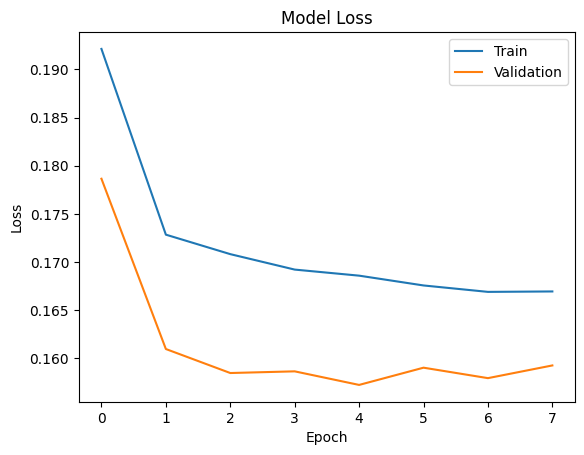

In [16]:
# Plot the training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [207]:
predictions = model.predict(X_test)
predictions[:10]

15728/15728 [==============================] - 16s 1ms/step


array([[0.0488631 ],
       [1.        ],
       [0.06186907],
       ...,
       [1.        ],
       [0.05209024],
       [0.0488631 ]], dtype=float32)

In [201]:
predictions1 = model.predict(X_test1)
predictions1[:10]

9793/9793 [==============================] - 10s 992us/step


array([[0.0488631 ],
       [0.17408939],
       [0.0488631 ],
       [0.0488631 ],
       [0.0488631 ],
       [0.0488631 ],
       [0.0488631 ],
       [0.0488631 ],
       [0.0488631 ],
       [0.0488631 ]], dtype=float32)

In [202]:
predictions2 = model.predict(X_test2)
predictions2[:10]

5935/5935 [==============================] - 6s 999us/step


array([[1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [0.96699846],
       [1.        ],
       [1.        ],
       [1.        ]], dtype=float32)

In [216]:
predictions_list = []
D_count = 0
Lambda_count = 0
unclear = 0
for pred in predictions2:
    if float(pred) > 0.5:
        predictions_list.append(int(1))
        Lambda_count+=1
    elif float(pred) < 0.5:
        predictions_list.append(int(0))
        D_count+=1
    else:
        unclear+=1
        
print("$D^+$ Count: {}".format(D_count))
print("$\Lambda_C^+ Count: {}".format(Lambda_count))
print("Unknown Particle Count: {}".format(unclear))
np.shape(predictions2)

$D^+$ Count: 23994
$\Lambda_C^+ Count: 165911
Unknown Particle Count: 0


(189905, 1)

In [218]:
accuracy = np.mean(predictions_list == y_test2)
print("Accuracy: {:.2%}".format(accuracy))

y_test2D

Accuracy: 87.37%


275826    1
76199     1
437361    1
740449    1
500489    1
         ..
583454    1
363819    1
689529    1
507183    1
143338    1
Name: DMesons_pdgId, Length: 189905, dtype: int64

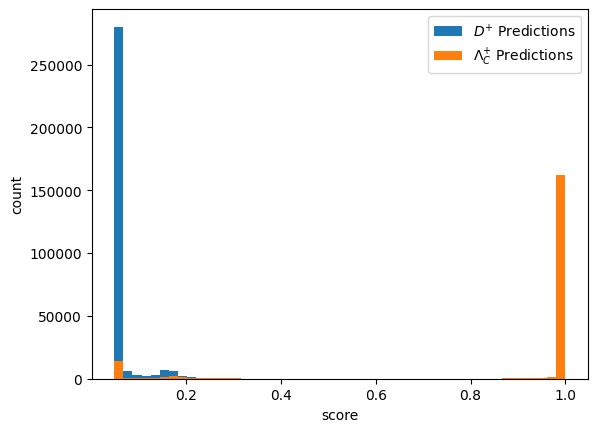

In [82]:
#arrays = np.concatenate((predictions1, predictions2))
hist = plt.hist(predictions1, bins = 50, label = "$D^{+}$ Predictions")
hist2 = plt.hist(predictions2, bins = 50, label = "$\Lambda_C^{+}$ Predictions")
plt.xlabel("score")
plt.ylabel("count")
plt.legend()
plt.show()